<a href="https://colab.research.google.com/github/Mahrokh-Eb/Deep-Learning-with-Python/blob/main/catVSdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cat VS dog Classification 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/dogVsCat

/content/drive/MyDrive/dogVsCat


In [4]:
#!pip3 install bcolz  

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

In [6]:
use_gpu

True

# Kaggle

In [7]:
#pip install kaggle

In [8]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/dogVsCat/drive"

In [9]:
#Change your present working directory
%cd /content/drive/MyDrive/dogVsCat/kaggle

/content/drive/MyDrive/dogVsCat/kaggle


In [10]:
pwd

'/content/drive/MyDrive/dogVsCat/kaggle'

In [11]:
#!kaggle competitions download -c dogs-vs-cats

In [12]:
!ls

DR  sampleSubmission.csv  test1  train


In [13]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

In [14]:
DATA_DIR ='/content/drive/MyDrive/dogVsCat/kaggle/'

sz = 224
batch_size = 16

In [15]:
os.listdir(DATA_DIR)

['sampleSubmission.csv', 'DR', 'test1', 'train']

In [16]:
trn_dir = f'{DATA_DIR}train'
test_dir = f'{DATA_DIR}test1'

In [17]:
trn_fnames = glob.glob(f'{trn_dir}/*/*')
trn_fnames[:5]

['/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11500.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11501.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11502.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11503.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11504.jpg']

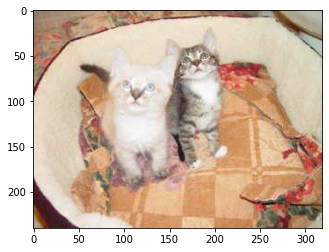

In [18]:
img = plt.imread(trn_fnames[715])
plt.imshow(img);

In [27]:
'''from __future__ import print_function
import pandas as pd
import shutil
import os
import sys

labels = pd.read_csv(r'/content/drive/MyDrive/dogVsCat/kaggle/sampleSubmission.csv')

train_dir =r'/content/drive/MyDrive/dogVsCat/kaggle/train'
DR = r'/content/drive/MyDrive/dogVsCat/kaggle/DR0'
if not os.path.exists(DR):
    os.mkdir(DR)

for filename, class_name in labels.values:
    # Create subdirectory with `class_name`
    if not os.path.exists(DR + str(class_name)):
        os.mkdir(DR + str(class_name))
    src_path = train_dir + '/'+'cat.'+ str(filename) + '.jpg'
    dst_path = DR + str(class_name) + '/' + str(filename) + '.jpg'
    try:
        shutil.copyfile(src_path, dst_path)
        print("sucessful")
    except IOError as e:
        print('Unable to copy file {} to {}'
              .format(src_path, dst_path))
    except:
        print('When try copy file {} to {}, unexpected error: {}'
              .format(src_path, dst_path, sys.exc_info()))'''

'from __future__ import print_function\nimport pandas as pd\nimport shutil\nimport os\nimport sys\n\nlabels = pd.read_csv(r\'/content/drive/MyDrive/dogVsCat/kaggle/sampleSubmission.csv\')\n\ntrain_dir =r\'/content/drive/MyDrive/dogVsCat/kaggle/train\'\nDR = r\'/content/drive/MyDrive/dogVsCat/kaggle/DR0\'\nif not os.path.exists(DR):\n    os.mkdir(DR)\n\nfor filename, class_name in labels.values:\n    # Create subdirectory with `class_name`\n    if not os.path.exists(DR + str(class_name)):\n        os.mkdir(DR + str(class_name))\n    src_path = train_dir + \'/\'+\'cat.\'+ str(filename) + \'.jpg\'\n    dst_path = DR + str(class_name) + \'/\' + str(filename) + \'.jpg\'\n    try:\n        shutil.copyfile(src_path, dst_path)\n        print("sucessful")\n    except IOError as e:\n        print(\'Unable to copy file {} to {}\'\n              .format(src_path, dst_path))\n    except:\n        print(\'When try copy file {} to {}, unexpected error: {}\'\n              .format(src_path, dst_path, 

## Datasets and Dataloaders in PyTorch

In [20]:
train_ds = datasets.ImageFolder(trn_dir)

In [47]:
print(train_ds)

Dataset ImageFolder
    Number of datapoints: 37499
    Root location: /content/drive/MyDrive/dogVsCat/kaggle/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.244, 0.225])
           )


In [21]:
train_ds.classes

['cat', 'dog']

In [22]:
train_ds.class_to_idx

{'cat': 0, 'dog': 1}

In [23]:
train_ds.root

'/content/drive/MyDrive/dogVsCat/kaggle/train'

In [24]:
train_ds.imgs[:3]

[('/content/drive/MyDrive/dogVsCat/kaggle/train/cat/1.jpg', 0),
 ('/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10.jpg', 0),
 ('/content/drive/MyDrive/dogVsCat/kaggle/train/cat/100.jpg', 0)]

In [25]:
type(train_ds.transform)

NoneType

In [26]:
# train_ds.targets #labels=y_train

In [28]:
# we have a list on train_ds.img, we get first item of each tuple in the list
tuple_list = train_ds.imgs
first_tuple_elements = []

for a_tuple in tuple_list:
	first_tuple_elements.append(a_tuple[0])
print(first_tuple_elements)


['/content/drive/MyDrive/dogVsCat/kaggle/train/cat/1.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/100.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/1000.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10000.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10001.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10002.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10003.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10004.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10005.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10006.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10007.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10008.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10009.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/1001.jpg', '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/10010.jpg', '/content/drive/My

In [29]:
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_val, y_train, y_val = train_test_split(first_tuple_elements, train_ds.targets, test_size=0.25, random_state=1)

In [37]:
X_train[:3]

['/content/drive/MyDrive/dogVsCat/kaggle/train/dog/dog.5864.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/dog/cat.2809.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/dog/cat.3322.jpg']

In [80]:
type(train_ds)
train_ds
len(train_ds)

37499

# Transformations

In [44]:
# Python program to convert a list to string
    
# Function to convert  
def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for ele in s: 
        str1 += ele  
    
    # return string  
    return str1 
        
        
# Driver code    
s = ['Geeks', 'for', 'Geeks']
print(listToString(s)) 

listToString(X_train)

GeeksforGeeks


'/content/drive/MyDrive/dogVsCat/kaggle/train/dog/dog.5864.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/dog/cat.2809.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/dog/cat.3322.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/dog/cat.5107.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/dog/cat.6356.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/dog/cat.4884.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/cat/9889.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/dog/cat.3513.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/cat/5672.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11175.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/dog/dog.1525.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/dog/dog.10298.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/cat/6761.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/dog/dog.11026.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11063.jpg/content/drive/MyDrive/dogVsCat/kaggle/train/dog/cat.6144.jpg/content/drive/MyDrive/dogVsCat/kaggle/

In [50]:
tfms = transforms.Compose([transforms.Resize((sz, sz)), 
                          transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.244, 0.225])
                          ])
train_ds = datasets.ImageFolder(trn_dir, tfms)
#valid_ds = datasets.ImageFolder(X_val, tfms)

In [51]:
len(train_ds)

37499

# Dataloader

In [52]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


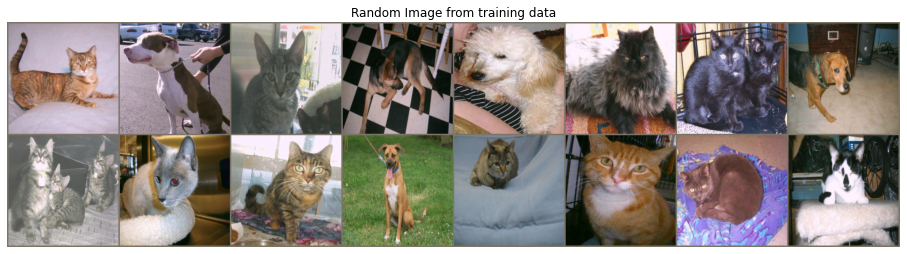

In [53]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16,12))
imshow(out, title='Random Image from training data')

# Model: CNN

In [54]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
                nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56* 56* 32, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [55]:
model = SimpleCNN()

if use_gpu:
    model = model.cuda()

In [56]:
use_gpu

True

## Loss Function and Optimizer

In [60]:
criterian = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

In [94]:
loss.data

tensor(0.5190, device='cuda:0')

## Train

In [95]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterian(outputs, targets)
        losses += [loss.data]
        
        # backward pass
        loss.backward()
       
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
          % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size,loss.data))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [ 1/10], Step [ 50/2343], Loss: 0.7089
Epoch [ 1/10], Step [100/2343], Loss: 0.7082
Epoch [ 1/10], Step [150/2343], Loss: 0.6224
Epoch [ 1/10], Step [200/2343], Loss: 0.5294
Epoch [ 1/10], Step [250/2343], Loss: 0.6648
Epoch [ 1/10], Step [300/2343], Loss: 0.6211
Epoch [ 1/10], Step [350/2343], Loss: 0.7349
Epoch [ 1/10], Step [400/2343], Loss: 0.6211
Epoch [ 1/10], Step [450/2343], Loss: 0.5427
Epoch [ 1/10], Step [500/2343], Loss: 0.7122
Epoch [ 1/10], Step [550/2343], Loss: 0.5846
Epoch [ 1/10], Step [600/2343], Loss: 0.5720
Epoch [ 1/10], Step [650/2343], Loss: 0.7779
Epoch [ 1/10], Step [700/2343], Loss: 0.5789
Epoch [ 1/10], Step [750/2343], Loss: 0.6229
Epoch [ 1/10], Step [800/2343], Loss: 0.5801
Epoch [ 1/10], Step [850/2343], Loss: 0.4655
Epoch [ 1/10], Step [900/2343], Loss: 0.7634
Epoch [ 1/10], Step [950/2343], Loss: 0.4878
Epoch [ 1/10], Step [1000/2343], Loss: 0.6674
Epoch [ 1/10], Step [1050/2343], Loss: 0.6966
Epoch [ 1/10], Step [1100/2343], Loss: 0.6216
Epoch [

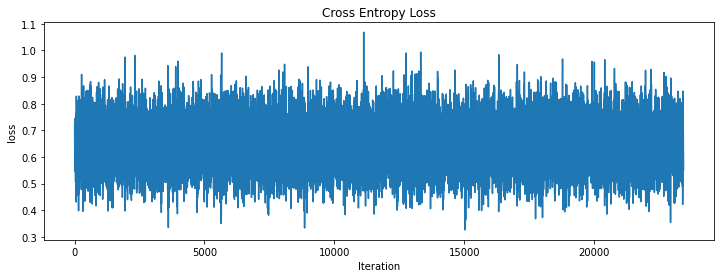

In [96]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');